# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [70]:
# Load the libraries as required.
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np
import shap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [71]:
# Load data

cat_file = os.path.join(
    os.getenv("SRC_DIR")+'/data/fires/','forestfires.csv'
)

columns = [
    'x', 'y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv(cat_file, header = 0, names = columns))

fires_dt.info()
fires_dt.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       517 non-null    int64  
 1   y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   ffmc    517 non-null    float64
 5   dmc     517 non-null    float64
 6   dc      517 non-null    float64
 7   isi     517 non-null    float64
 8   temp    517 non-null    float64
 9   rh      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Index(['x', 'y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
       'wind', 'rain', 'area'],
      dtype='object')

# Get X and Y

Create the features data frame and target data.

In [72]:
# Define features and target
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']


# Identify column types
numerical_columns = ['x', 'y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_columns = ['month', 'day']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20,random_state=7)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [73]:
#SImple Preprocessing

#Scaling
std_scaler = StandardScaler()

#One-hot encoding
onehot = OneHotEncoder(handle_unknown='ignore')

preproc1 = ColumnTransformer([
    ('num', std_scaler, numerical_columns),
    ('cat', onehot, categorical_columns)
],remainder='drop')

preproc1

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [74]:

preproc2 = ColumnTransformer([
    ('num', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scale', StandardScaler())]), numerical_columns),
    ('cat', onehot, categorical_columns)
], remainder='drop')

preproc2

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,method,'yeo-johnson'
,standardize,True
,copy,True


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [75]:
# Pipeline A = preproc1 + baseline
ridge = Ridge(random_state=7)

pipe_a = Pipeline([
    ('preproc1', preproc1),
    ('regressor',ridge)
])

pipe_a

,steps,"[('preproc1', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [76]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline([
    ('preproc2', preproc2),
    ('regressor',ridge)
])

pipe_b

,steps,"[('preproc2', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [77]:
# Pipeline C = preproc1 + advanced model
rf = RandomForestRegressor(random_state=7)
pipe_c = Pipeline([
    ('preproc1', preproc1),
    ('regressor',rf)
])

pipe_c

,steps,"[('preproc1', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline([
    ('preproc2', preproc2),
    ('regressor',rf)
])

pipe_d  

,steps,"[('preproc2', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [79]:
param_grids = {
    'pipe_a': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky', 'saga']
    },
    'pipe_b': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky', 'saga']
    },
    'pipe_c': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 5, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    'pipe_d': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 5, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
}

param_grids

{'pipe_a': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
  'regressor__solver': ['auto', 'svd', 'cholesky', 'saga']},
 'pipe_b': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
  'regressor__solver': ['auto', 'svd', 'cholesky', 'saga']},
 'pipe_c': {'regressor__n_estimators': [50, 100, 200],
  'regressor__max_depth': [3, 5, 10],
  'regressor__min_samples_split': [2, 5, 10],
  'regressor__min_samples_leaf': [1, 2, 4]},
 'pipe_d': {'regressor__n_estimators': [50, 100, 200],
  'regressor__max_depth': [3, 5, 10],
  'regressor__min_samples_split': [2, 5, 10],
  'regressor__min_samples_leaf': [1, 2, 4]}}

In [80]:
pipelines = {
    'pipe_a': pipe_a,
    'pipe_b': pipe_b,
    'pipe_c': pipe_c,
    'pipe_d': pipe_d
}

scoring = 'neg_root_mean_squared_error'  # For regression tasks

#Store best results
best_models = {}
cv_results = {}
pipelines

{'pipe_a': Pipeline(steps=[('preproc1',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['x', 'y', 'ffmc', 'dmc',
                                                    'dc', 'isi', 'temp', 'rh',
                                                    'wind', 'rain']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['month', 'day'])])),
                 ('regressor', Ridge(random_state=7))]),
 'pipe_b': Pipeline(steps=[('preproc2',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('power',
                                                                    PowerTransformer()),
                                                                   ('scale',
                                      

In [81]:
# Perform Grid Search with Cross-Validation

for name, model in pipelines.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring=scoring,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    cv_results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
    }
    print(f"{name}:")
    print(f"  Best Params: {grid.best_params_}")
    print(f"  Best CV RMSE: {-grid.best_score_:.4f}")

pipe_a:
  Best Params: {'regressor__alpha': 100.0, 'regressor__solver': 'saga'}
  Best CV RMSE: 54.5326
pipe_b:
  Best Params: {'regressor__alpha': 100.0, 'regressor__solver': 'saga'}
  Best CV RMSE: 54.4553
pipe_c:
  Best Params: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
  Best CV RMSE: 60.1766
pipe_d:
  Best Params: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
  Best CV RMSE: 60.1942


In [82]:
#Evaluate on test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name}:")
    print(f"  Test RMSE: {rmse:.4f}")
    print(f"  Test MAE: {mae:.4f}")
    print(f"  Test R^2: {r2:.4f}")


pipe_a:
  Test RMSE: 44.3894
  Test MAE: 21.7018
  Test R^2: -0.0164
pipe_b:
  Test RMSE: 44.6056
  Test MAE: 21.5844
  Test R^2: -0.0263
pipe_c:
  Test RMSE: 51.3253
  Test MAE: 23.8660
  Test R^2: -0.3589
pipe_d:
  Test RMSE: 51.2927
  Test MAE: 23.8697
  Test R^2: -0.3571


In [83]:
r_model = best_models['pipe_a']  # Based on previous results, choosing pipe_a
#for the best Ridge model
coefficients = r_model.named_steps['regressor'].coef_

# Retrieve feature names after preprocessing
ohe = r_model.named_steps['preproc1'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_columns)
feature_names = numerical_columns + list(ohe_features)

#Create importance DataFrame using coefficients
importances_df = pd.DataFrame({'feature': feature_names, 'importance': coefficients})
print(importances_df.sort_values('importance', ascending=False).head(10))


      feature  importance
24    day_sat    6.996831
3         dmc    4.329529
21  month_sep    4.306486
6        temp    3.623178
0           x    3.257931
8        wind    2.536714
26    day_thu    1.937384
1           y    1.234963
13  month_feb    0.869612
10  month_apr    0.350149


Based on the previous results, seems that saturday and temperature are the features that have most influence in the burned area predictions

In [87]:
# For the best Random Forest model
rf_model = best_models['pipe_c']  # Based on previous results, choosing pipe_c
coefficients = rf_model.named_steps['regressor'].feature_importances_

# Retrieve feature names after preprocessing
ohe = rf_model.named_steps['preproc1'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_columns)
feature_names = numerical_columns + list(ohe_features)
importances_df = pd.DataFrame({'feature': feature_names, 'importance': coefficients})

print(importances_df.sort_values('importance', ascending=False).head(10))

    feature  importance
6      temp    0.388898
3       dmc    0.130460
7        rh    0.085809
4        dc    0.082152
24  day_sat    0.072703
0         x    0.067225
8      wind    0.051803
1         y    0.051412
2      ffmc    0.024154
5       isi    0.019322


However, with the pipeline C, Seems that temp is the most important predictor, meaning it has the strongest effect on the model's output.

# Evaluate

+ Which model has the best performance?

Pipeline A (pipe_a) has the best performance. It has the lowest test RMSE and MAE, and the least negative R^2 value among all models.
This means it makes the smallest prediction errors and fits the data better than the other pipeline

# Export

+ Save the best performing model to a pickle file.

In [88]:
import pickle
with open('best_forest_fire_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

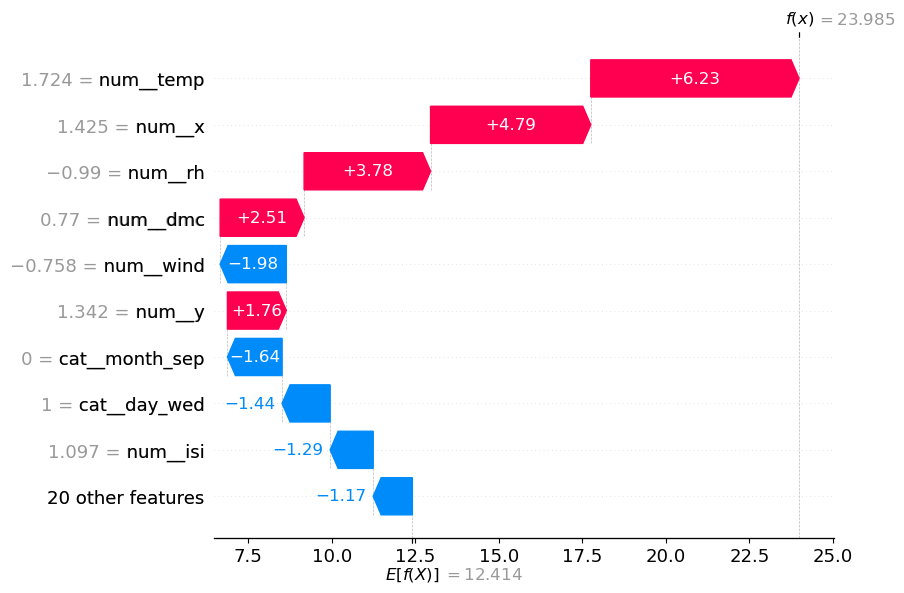

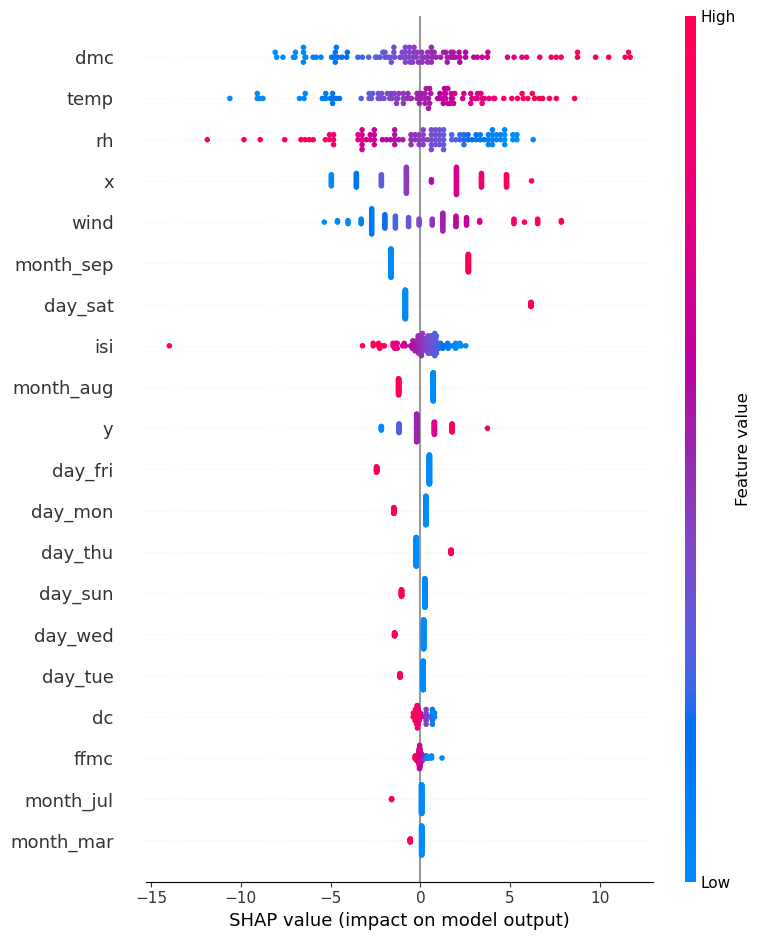

In [95]:
best_model = best_models['pipe_a']
x_preprocessed = best_model.named_steps['preproc1'].transform(X_test)
model = best_model.named_steps['regressor']
feature_names = np.concatenate([numerical_columns, best_model.named_steps['preproc1'].named_transformers_['cat'].get_feature_names_out(categorical_columns)])

explainer = shap.Explainer(model, x_preprocessed,feature_names = best_model.named_steps['preproc1'].get_feature_names_out())

shap_values = explainer(x_preprocessed)
shap.plots.waterfall(shap_values[2])
shap.summary_plot(shap_values, features=x_preprocessed, feature_names=feature_names)




In [90]:
feature_names = best_model.named_steps['preproc1'].get_feature_names_out()
shap_importance = np.abs(shap_values.values).mean(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_importance
}).sort_values(by='mean_abs_shap', ascending=True)
importance_df

,feature,mean_abs_shap
14,cat__month_jan,0.000000
19,cat__month_nov,0.000000
20,cat__month_oct,0.000000
18,cat__month_may,0.000617
10,cat__month_apr,0.006801
12,cat__month_dec,0.018728
13,cat__month_feb,0.033447
9,num__rain,0.066580
16,cat__month_jun,0.066882
17,cat__month_mar,0.122417


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    Most important features, are the ones which exhibit highest mean absolute SHAP Values:
    These features are:
    1. Temperature (num_temp): Temeperature emerges as the most critical predictor
    2. DMC (num_dmc): DMC comes second in importance
    3. Num_x: X-coordinate spatial location
    4. rh: Relative humidity
    5. wind: Wind Speed

    - In general, across the complete training set, which features are the most and least important.

        Most important: Temperature, DMC, num_x, rh, and wind.

        Least important: cat_month_apr, cat_month_may, cat_month_oct and num_rain

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

The Features to consider removing are:
1. Seasonal month with nearly zero importance: April, MAy, January and October show no predictive power.
2. num_rain: Rainfaill appears to contribute minimally (0.018840)
3. Several low-impact day categories: Weekdays show limited predictivie value compared to Saturday


By reducing the number of features, the complexity of the model will also be reduced, there is a hance to reduce overfitting (noise reduction) and improve computational efficiency (reducing training and prediction time).


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.